In [1]:
import numpy as np
from random import shuffle as sfl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
import scipy
import itertools



%matplotlib inline


/Users/Joke/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Define hrf functions

In [2]:
def spm_Gpdf(s,h,l):
    s = np.array(s)
    res = (h-1)*np.log(s) + h*np.log(l) - l*s - np.log(gamma(h))
    return np.exp(res)

def canonical(resolution):
    # translated from spm_hrf
    p=[6,16,1,1,6,0,32]
    dt = resolution/16.
    s = np.array(xrange(int(p[6]/dt+1)))
    #HRF sampled at 0.1 s
    hrf = spm_Gpdf(s,p[0]/p[2],dt/p[2]) - spm_Gpdf(s,p[1]/p[3],dt/p[3])/p[4]
    hrf = hrf[[int(x) for x in np.array(xrange(int(p[6]/resolution+1)))*16.]]
    hrf = hrf/np.sum(hrf)
    # duration of the HRF
    durhrf = 32.0
    # length of the HRF parameters in resolution scale
    laghrf = int(np.ceil(durhrf/resolution))
    hrf = hrf[:laghrf]

    return {"basishrf":hrf,"laghrf":laghrf}


# Define class for the experiment


 There are a few settings that can be changed in the functions:
 The total number of trials: 256
 The ITI: 6 seconds --> note: we assume a fixed ITI, could (and maybe should) be jittered !
 The resolution: 0.1 seconds
 The gains: range 10\$ - 40\$, by 2\$ (as Tom et al.)
 The losses: range 5\$ - 20\$, by 1\$ (as Tom et al.)

In [3]:
def shuffle_in_unison(a, b):
        assert len(a) == len(b)
        shuffled_a = np.empty(len(a), dtype=int)
        shuffled_b = np.empty(len(b), dtype=int)
        permutation = np.random.permutation(len(a))
        for old_index, new_index in enumerate(permutation):
                shuffled_a[new_index] = a[old_index]
                shuffled_b[new_index] = b[old_index]
        return shuffled_a, shuffled_b
    
    
class experiment(object):
    def __init__(self,ITI,ntrials=256,resolution=0.1):
        self.ntrials = ntrials
        self.ITI = ITI
        self.AvgITI = round(np.mean(ITI))
        self.resolution = resolution
        self.xaxis = np.arange(0,ntrials*self.AvgITI,resolution)
        #was - self.xaxis = np.arange(0,ntrials*ITI,resolution)

     
    #was -def get_experiment(self):
    def  get_experiment(self,ITI):

        #was - self.onsets = range(0,int(self.ntrials*self.ITI/self.resolution),int(self.ITI/self.resolution))
        self.onsets = [int(x) for x in np.cumsum(ITI, dtype=float)]
        #print self.onsets
        #was -self.gains = np.round(np.random.uniform(10,40,self.ntrials)/2)*2
        #was -self.losses = np.round(np.random.uniform(5,20,self.ntrials))
        largeRange= range(10,41,2)
        smallRange= range(5,21)
        RangeLen=len(largeRange)
        LossesVec=list(itertools.chain.from_iterable(map(lambda x: (list(itertools.repeat(x,RangeLen))),smallRange)))
        GainsVec=largeRange*RangeLen
        [self.gains , self.losses] = shuffle_in_unison(GainsVec,LossesVec)
        distance = self.gains-self.losses
        
        #print self.AvgITI
        #print int(self.ntrials*self.AvgITI/self.resolution)
        reg_task = np.zeros(int(self.ntrials*self.AvgITI/self.resolution))
        reg_task[self.onsets] = 1
        reg_task_c = np.convolve(reg_task,canonical(self.resolution)['basishrf'][:len(reg_task)])
        
        reg_gain = np.zeros(int(self.ntrials*self.AvgITI/self.resolution))
        reg_gain[self.onsets] = (self.gains-np.mean(self.gains))/np.std(self.gains)
        reg_gain_c = np.convolve(reg_gain,canonical(self.resolution)['basishrf'][:len(reg_gain)])
        
        reg_loss = np.zeros(int(self.ntrials*self.AvgITI/self.resolution))
        reg_loss[self.onsets] = (self.losses-np.mean(self.losses))/np.std(self.losses)
        reg_loss_c = np.convolve(reg_loss,canonical(self.resolution)['basishrf'][:len(reg_loss)])

        reg_dist = np.zeros(int(self.ntrials*self.AvgITI/self.resolution))
        reg_dist[self.onsets] = (distance-np.mean(distance))/np.std(distance)
        reg_dist_c = np.convolve(reg_dist,canonical(self.resolution)['basishrf'][:len(reg_dist)])
      
        self.design = np.array([reg_task,reg_gain,reg_loss,reg_dist])
        self.design_c = np.array([reg_task_c,reg_gain_c,reg_loss_c,reg_dist_c])
               
        return self

    def compute_efficiency(self,contrasts):
        
        C = contrasts
        
        XtX = np.dot(EXP.design_c,EXP.design_c.T)  
        invZ = scipy.linalg.inv(XtX)
        CMC = np.matrix(C)*np.matrix(invZ)*np.matrix(C.T)
        
        self.Aopt = float(len(C) / np.matrix.trace(CMC))
        
        return self

# Example of creating a random design

In [4]:
# Jittered ITI with an avarage of 8 s 
ITIs=map(lambda x: round(x),(np.random.normal(loc=8, scale=1, size=256)))


In [5]:
print min(ITIs) # to make sure we have enough time for the response (4 s for response + fixation)

5.0


In [6]:
EXP = experiment(ITIs)
EXP.get_experiment(ITIs)
print EXP.onsets
#was -EXP = experiment()
#was -EXP.get_experiment()


[8, 17, 25, 32, 39, 47, 54, 65, 74, 82, 89, 98, 106, 114, 121, 128, 136, 144, 152, 159, 166, 174, 181, 190, 199, 207, 216, 223, 232, 241, 247, 254, 263, 271, 277, 284, 291, 299, 306, 314, 323, 331, 339, 349, 357, 364, 373, 382, 390, 398, 407, 416, 424, 432, 439, 447, 455, 464, 472, 481, 489, 497, 505, 512, 520, 530, 539, 546, 554, 562, 571, 578, 586, 593, 601, 609, 617, 624, 631, 637, 645, 654, 663, 670, 678, 686, 693, 701, 709, 717, 724, 732, 740, 749, 759, 767, 775, 784, 793, 802, 810, 817, 828, 835, 845, 851, 859, 865, 872, 880, 889, 897, 905, 914, 924, 933, 940, 949, 957, 965, 972, 980, 986, 994, 1002, 1010, 1018, 1026, 1034, 1041, 1049, 1058, 1065, 1074, 1082, 1090, 1099, 1108, 1115, 1122, 1130, 1139, 1151, 1160, 1166, 1176, 1186, 1195, 1203, 1212, 1221, 1229, 1238, 1245, 1254, 1262, 1268, 1275, 1282, 1290, 1298, 1308, 1316, 1326, 1334, 1343, 1351, 1359, 1365, 1374, 1381, 1389, 1398, 1406, 1416, 1423, 1432, 1439, 1446, 1453, 1461, 1470, 1477, 1485, 1493, 1500, 1509, 1518, 1526, 15

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [7]:
# print out gains and losses choice
print("Gains: %s"%(str(EXP.gains)))
print("Losses: %s"%(str(EXP.losses)))

Gains: [22 10 10 10 12 32 22 28 20 16 10 16 32 16 34 34 30 18 26 10 34 18 18 10 28
 22 36 38 24 12 32 28 38 26 20 20 18 16 24 28 38 28 28 20 22 10 40 38 34 30
 24 36 22 36 16 28 32 16 16 28 24 38 40 24 34 10 18 18 24 34 32 18 10 20 26
 36 36 22 14 30 32 32 26 30 14 22 36 18 20 26 24 26 26 22 38 10 18 12 18 36
 38 40 10 36 18 30 34 34 20 40 20 26 26 20 40 34 14 20 12 28 12 10 32 22 26
 14 10 18 26 34 24 20 38 30 28 24 16 18 34 38 26 12 32 20 12 36 14 18 32 22
 22 16 24 38 16 40 32 28 32 28 16 40 30 22 40 36 38 14 10 12 26 10 38 40 16
 22 32 14 20 30 34 28 14 12 26 12 36 14 32 14 38 38 12 10 20 32 36 40 30 36
 30 24 36 34 38 14 24 40 12 40 18 12 28 28 28 18 40 16 32 20 14 30 30 14 38
 24 24 40 34 16 20 14 36 24 12 26 16 40 14 30 12 40 26 14 30 30 34 22 24 22
 30 12 22 34 36 16]
Losses: [15  8 15 17  8  8 17 12 13  8 16 18 20 15 12 14 17 16  6 11 13 18  7 19  8
 18 16  8 19  7 16 14 20 13 18 12 13 17  7 18 13  5 15 16 14 14 11 14 17  5
 18 18 12  8 10 11  5 19 13  6 14  6 19 11 16 20  9 1

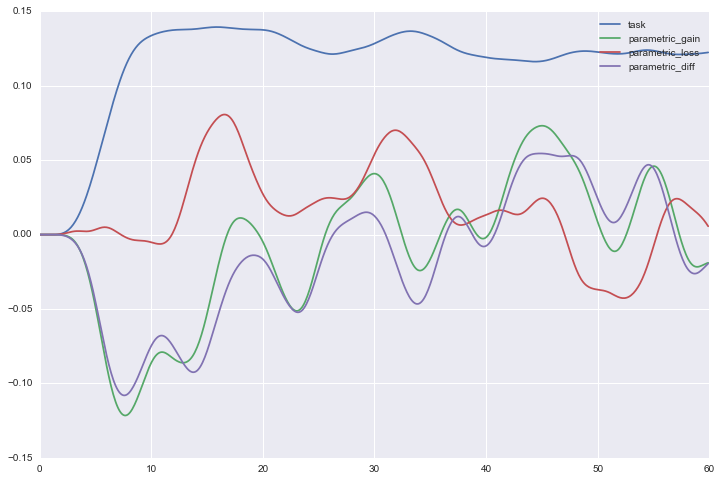

In [8]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(EXP.xaxis[:600],EXP.design_c.T[:600,x],label=labs[x])
plt.legend()

# Contrasts


In [9]:
# To compute the efficiency of the design, we also need to define the contrasts. 
#Here I defined a contrast of main effect of task (&) difference between loss and gain trials


In [10]:
conts = np.array([
        [1,0,0,0],
        [0,1,-1,0]
    ])

EXP.compute_efficiency(conts)
print(EXP.Aopt)

1.51644895546e-15


# Extract optimal design

In [14]:
seed

254

In [15]:
allexp = []
for seed in range(1000):
    EXP = experiment(ITIs)
    EXP.get_experiment(ITIs)
    conts = np.array([
            [1,0,0,0],
            [0,1,-1,0]
        ])
    try:
        EXP.compute_efficiency(conts)
    except LinAlgError:
        continue
    #print("Random experiment %i: efficiency %f"%(seed,EXP.Aopt))
    out = {"opt":EXP.Aopt,"gains":EXP.gains,"losses":EXP.losses,"experiment":EXP.design_c,"xaxis":EXP.xaxis}
    allexp.append(out)
    EXP = None

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


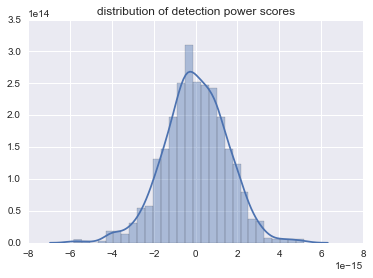

In [16]:
# Distribution of optimisation scores:

opt = [x['opt'] for x in allexp]

ax = plt.axes()
sns.distplot(opt,ax=ax)
ax.set_title("distribution of detection power scores")

# Optimal design:


In [23]:
optind = int(np.where(np.array(opt)==np.max(opt))[0])
optimum = allexp[optind]
# compute efficiency

print(optimum)

{'opt': 5.1838836917297695e-15, 'losses': array([18, 12, 20, 16, 19, 15, 18, 19,  8, 10, 13,  9, 20, 15,  9,  7, 16,
        9,  6, 17,  9, 18, 18,  8,  6, 10, 14, 12,  9,  5,  6,  9,  6,  5,
       15, 18, 20, 15,  6,  8, 19, 14, 10,  6, 16, 12,  9, 18, 12,  8,  8,
        9, 16, 13,  6,  5, 17,  9, 14, 14, 20, 17, 10, 12, 18, 11,  7, 19,
        8, 18, 11,  6, 19, 11, 13, 10, 16,  6,  5, 20, 18,  9, 15, 19,  9,
       12, 11,  6, 17, 11, 11, 13, 17, 11, 15,  7, 16, 10,  9,  7,  5,  8,
       10, 19, 12,  5,  6, 10, 17, 20, 13, 15,  5, 13,  8, 16, 11,  7,  8,
       11, 16, 15,  6, 13, 16, 13, 19, 12, 12, 15,  7, 14, 14, 20, 14, 11,
        7,  5,  7,  7, 14, 19,  7, 14, 19, 20, 16, 11, 14, 18, 13,  8, 20,
       17, 16,  5, 10, 10, 10, 20, 18, 17,  8,  5, 16, 17,  7, 14,  7, 17,
       10, 20, 19, 11, 17, 13, 14, 19, 14, 17, 12, 20, 15, 10, 15,  6, 15,
        5, 17, 12,  7, 18,  8, 12, 15, 20, 16,  7, 20, 10, 12,  8,  9,  5,
       19,  7, 14, 15, 19, 16,  8,  9, 10, 13, 12,  5, 11,

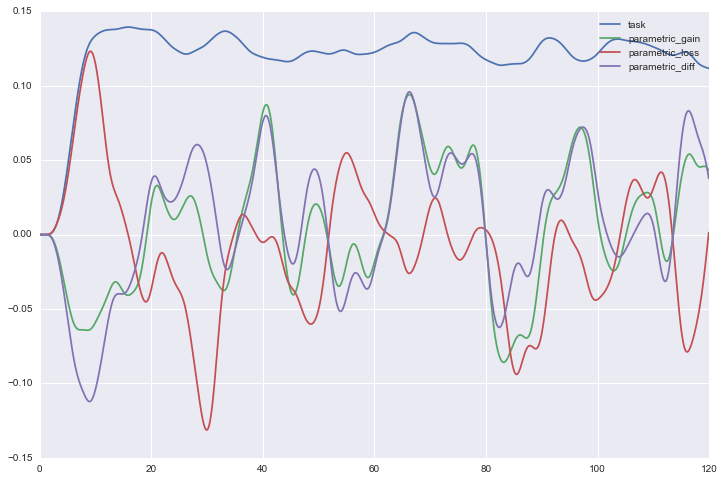

In [24]:
# generate figure
plt.figure(figsize=(12,8))
labs = ["task",'parametric_gain','parametric_loss','parametric_diff']
for x in range(4):
    plt.plot(optimum['xaxis'][:1200],optimum['experiment'].T[:1200,x],label=labs[x])

plt.legend()